In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import re
from tensorflow.keras import layers, models
import sklearn.metrics as metrics
from numpy.fft import fft, fftfreq, fftshift
import scipy.signal as signal
from tensorflow_addons.metrics import F1Score
import tensorflow_addons as tfa

%matplotlib notebook

In [2]:
data_root = Path('.')/'data'

remove_movement = True
grouped = True

trim = True
filter_iqr = False

perform_fft = True

use_cnn_lstm = False

In [3]:
window_size = 100
step_size = 50

In [4]:
sensor_pos = 'Chest'
sensor_side = 'Right'

In [5]:
# Load data files
target_folder = data_root/'2020'
student_pattern = "s\d{7}"

files = {}
for (dirpath, dirnames, filenames) in os.walk(target_folder):
  s_match = re.search(student_pattern, dirpath)
  # if regex matches, and files exist
  if s_match and filenames:
    s = s_match.group()
    # print(f"adding files for {s} (in {dirpath})")
    dir = Path(dirpath)
    try: files[s]
    except KeyError: files[s] = []
    # only accept .csv files
    files[s].extend([dir/f for f in filenames if f[-4:] == '.csv'])

print("File count:")
{k: len(v) for (k, v) in files.items()}

File count:


{'s1621503': 84,
 's1704037': 79,
 's1736273': 84,
 's1735229': 84,
 's1701688': 84,
 's1737472': 78,
 's1758009': 84,
 's1710228': 84,
 's1660711': 84,
 's1655560': 84,
 's1655552': 90,
 's1768094': 225,
 's1770036': 78,
 's1707651': 65,
 's2124639': 89,
 's2017768': 87,
 's1721039': 79,
 's1751093': 79,
 's1746788': 84,
 's1758499': 84,
 's1709221': 78,
 's1711507': 236,
 's1642301': 84,
 's1764751': 92,
 's1616573': 112}

In [6]:
ACTIVITY_CODE_TO_TFCODE_MAPPING = {
  0:   0,   # "Sitting",
  4:   1,   # "Sitting bent forward",
  5:   2,   # "Sitting bent backward",
  1:   3,   # "Walking at normal speed",
  100: 4,   # "Standing",
  2:   5,   # "Lying down on back",
  7:   6,   # "Lying down left",
  6:   7,   # "Lying down right",
  8:   8,   # "Lying down on stomach",
  9:   9,   # "Movement",
  11:  10,  # "Running",
  12:  11,  # "Climbing stairs",
  13:  12,  # "Descending stairs",
  31:  13,  # "Desk work"
}

ACTIVITY_TFCODE_TO_CODE_MAPPING = {
  0:  0,   # "Sitting",
  1:  4,   # "Sitting bent forward",
  2:  5,   # "Sitting bent backward",
  3:  1,   # "Walking at normal speed",
  4:  100, # "Standing",
  5:  2,   # "Lying down on back",
  6:  7,   # "Lying down left",
  7:  6,   # "Lying down right",
  8:  8,   # "Lying down on stomach",
  9:  9,   # "Movement",
  10: 11,  # "Running",
  11: 12,  # "Climbing stairs",
  12: 13,  # "Descending stairs",
  13: 31,  # "Desk work"
}

LABELS = {
    0:  "Sitting",
    1:  "Sitting bent forward",
    2:  "Sitting bent backward",
    3:  "Walking at normal speed",
    4:  "Standing",
    5:  "Lying down on back",
    6:  "Lying down left",
    7:  "Lying down right",
    8:  "Lying down on stomach",
    9:  "Movement",
    10: "Running",
    11: "Climbing stairs",
    12: "Descending stairs",
    13: "Desk work"
}

CLASSES = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 2,
    5: 3,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 5, 
    11: 6,
    12: 7,
    13: 0
}

CLASS_LABELS = {
    0: "Sitting",
    1: "Walking",
    2: "Standing",
    3: "Lying",
    4: "Movement",
    5: "Running",
    6: "Climbing Stairs",
    7: "Descending stairs"
}

CLASS_LABELS_NOMO = {
    0: "Sitting",
    1: "Walking",
    2: "Standing",
    3: "Lying",
    5: "Running",
    6: "Climbing Stairs",
    7: "Descending stairs"
}

In [7]:
from dataclasses import dataclass

header_size = 5

@dataclass
class Header:
  sensor_pos: str
  sensor_side: str
  act_type: str
  act_code: np.ndarray
  subject_id: str
  # https://stackoverflow.com/a/54863771/9184658
  def __post_init__(self):
    self.act_code = ACTIVITY_CODE_TO_TFCODE_MAPPING[int(self.act_code)]


@dataclass
class Activity:
  header: Header
  df: pd.DataFrame

def read_custom_file(filename):
  with open(filename) as f:
    head = [next(f).rstrip().split('# ')[1] for x in range(header_size)]
    header = Header(*[s.split(': ')[1] for s in head])
    # for l in head:
    #   print(l)
    # print(header)

    df = pd.read_csv(filename, header=header_size)
    return Activity(header, df)

In [8]:
def plot_respeck_fig(activity):
    fig = plt.figure(figsize=(10, 8))
    plt.plot(activity.df['accel_x'], label="accel_x")
    plt.plot(activity.df['accel_y'], label="accel_y")
    plt.plot(activity.df['accel_z'], label="accel_z")
    title = activity.header.subject_id + " " + activity.header.act_type  
    plt.title(title)  
    plt.legend()
    fig_name = "graphs/respeck_" + title + "_.png"
    plt.savefig(fig_name, bbox_inches='tight')
    return plt

In [9]:
def plot_array(arr):
    fig = plt.figure(figsize=(10, 8))
    plt.plot(arr[:,0], label="accel_x")
    plt.plot(arr[:,1], label="accel_y")
    plt.plot(arr[:,2], label="accel_z")
    plt.legend()
    return plt

In [10]:
act = read_custom_file(files["s1621503"][0])
act

Activity(header=Header(sensor_pos='Wrist', sensor_side='Right', act_type='Lying down right', act_code=7, subject_id='s1621503'), df=         timestamp  seq   accel_x   accel_y   accel_z
0    1601826499860    0  0.080566 -0.230530 -0.979065
1    1601826499938    1  0.081055 -0.230042 -0.978577
2    1601826500017    2  0.084961 -0.233215 -0.978333
3    1601826500096    3  0.083740 -0.231750 -0.979797
4    1601826500175    4  0.084473 -0.232483 -0.981750
..             ...  ...       ...       ...       ...
411  1601826532226  411  0.060547 -0.211487 -0.983704
412  1601826532305  412  0.060547 -0.207825 -0.989075
413  1601826532383  413  0.060303 -0.204407 -0.987366
414  1601826532462  414  0.061279 -0.208313 -0.986145
415  1601826532541  415  0.061523 -0.207092 -0.984924

[416 rows x 5 columns])

In [11]:
keys = ["accel_x", "accel_y", "accel_z"]

In [12]:
# split students into train and test set

students = list(files.keys())
print(len(students))

students.remove('s1735229')
students.remove('s1709221')

print(len(students))
    
split = int(len(students) * 0.8)
train_students = students[:split]
test_students = students[split:]

print(train_students)
print(test_students)

25
23
['s1621503', 's1704037', 's1736273', 's1701688', 's1737472', 's1758009', 's1710228', 's1660711', 's1655560', 's1655552', 's1768094', 's1770036', 's1707651', 's2124639', 's2017768', 's1721039', 's1751093', 's1746788']
['s1758499', 's1711507', 's1642301', 's1764751', 's1616573']


In [13]:
colours = ['#E52700', '#E35500', '#E18100', '#E0AD00', '#DED800', '#B7DD00', '#8ADB00', '#5DD900', '#31D800', '#06D600', '#00D523', '#00D34D', '#00D276', '#00D09F', '#00CEC7', '#00ABCD', '#0081CB', '#0058CA', '#002FC8', '#0007C6', '#1F00C5', '#4600C3', '#6C00C2', '#9200C0', '#B600BF']

In [14]:
# colours for graphs
STUDENT_COLOURS = dict(zip(students, colours))

In [15]:
def get_activities(files, students, window_size, sensor_pos, sensor_side):
    student_files = [files[student] for student in students]

    activities = [read_custom_file(filename) for student in student_files for filename in student]
            
    activities = [activity for activity in activities if not activity.df.empty and len(activity.df.index) >= window_size and activity.header.sensor_pos == sensor_pos and activity.header.sensor_side == sensor_side and len(activity.df['accel_x']) < 1000 and activity.header.act_type != "Sitting or standing" ]
    
    return activities

In [16]:
# read files for all students 
train_activities = get_activities(files, train_students, window_size, sensor_pos, sensor_side)

test_activities = get_activities(files, test_students, window_size, sensor_pos, sensor_side)


In [17]:
# stats
for activity_class in LABELS.values():
    activities = [len(activity.df.index) for activity in test_activities if activity.header.act_type == activity_class]
    num_files = len(activities)
    num_datapoints = sum(activities)
    print(activity_class, num_files, num_datapoints)

Sitting 5 2048
Sitting bent forward 5 1984
Sitting bent backward 5 2035
Walking at normal speed 3 1248
Standing 4 1568
Lying down on back 4 1568
Lying down left 4 1568
Lying down right 4 1568
Lying down on stomach 4 1536
Movement 3 1184
Running 3 1216
Climbing stairs 5 1568
Descending stairs 5 1632
Desk work 6 2766


In [18]:
train_student_acts = [activity.header.subject_id for activity in train_activities]
test_student_acts = [activity.header.subject_id for activity in test_activities]

In [19]:
def euclidean_norm(arr):
    return np.sum(np.abs(arr)**2,axis=1)**(1./2)

In [20]:
# X = data
# Y = labels

def create_data_arrays(activities):
    data = np.array([activity.df.get(keys).values for activity in activities], dtype=object)
    labels = np.array([activity.header.act_code for activity in activities])
    
    # sum each row 
    sums = [euclidean_norm(recording) for recording in data]
    
    data_means = [np.mean(s) for s in sums]
    data_stds = [np.std(s) for s in sums]
    
    return data, labels, data_means, data_stds

In [21]:
train_data_raw, train_labels_raw, train_means, train_stds = create_data_arrays(train_activities)
test_data_raw, test_labels_raw, test_means, test_stds = create_data_arrays(test_activities)

In [22]:
import itertools
def std_graphs(train_stds, train_labels_raw, test_stds, test_labels_raw, train_students_act, test_students_act):
    for i in range(14):
        activity = LABELS[i]
        stds_train = (list(itertools.compress(train_stds, (y == i for y in train_labels_raw))))
        stds_test = (list(itertools.compress(test_stds, (y == i for y in test_labels_raw))))
        
        train_studs = (list(itertools.compress(train_students_act, (y == i for y in train_labels_raw))))
        test_studs = (list(itertools.compress(test_students_act, (y == i for y in test_labels_raw))))

        train_colours = [STUDENT_COLOURS[s.lower()] for s in train_studs]
        test_colours = [STUDENT_COLOURS[s.lower()] for s in test_studs]
        
        y_max = max(max(stds_train), max(stds_test))
        y_min = min(min(stds_train), min(stds_test))
        
        width = 0.5
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        plt.title(activity)
        for i in range(len(stds_train)):
            ax1.bar(i, stds_train[i], width, color = train_colours[i])
        ax1.set_ylim([0, y_max])
        
        for i in range(len(stds_test)):
            ax2.bar(i, stds_test[i], width, color = test_colours[i])
        ax2.set_ylim([0, y_max])
        
        ax1.legend(train_studs, loc='upper left', bbox_to_anchor=(-0.8, 1))
        ax2.legend(test_studs, loc='upper left', bbox_to_anchor=(1.05, 1))
        
        #fig_name = "graphs/bar_std_" + activity + "_trimmed.png"
        #plt.savefig(fig_name, bbox_inches='tight')

In [23]:
#std_graphs(train_stds, train_labels_raw, test_stds, test_labels_raw, train_student_acts, test_student_acts)

In [24]:
def mean_graphs(train_means, train_labels, test_means, test_labels):
    for i in range(14):
        activity = LABELS[i]

        means_train = (list(itertools.compress(train_means, (y == i for y in train_labels))))
        means_test = (list(itertools.compress(test_means, (y == i for y in test_labels))))
        
        y_max = max(max(means_train), max(means_test))
        y_min = min(min(means_train), min(means_test))
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.bar(range(len(means_train)), means_train, color='green')
        ax1.set_ylim([0, y_max])
        ax2.bar(range(len(means_test)), means_test, color='green')
        ax2.set_ylim([0, y_max])
        plt.title(activity)
        #fig_name = "graphs/bar_mean_" + activity + "_original.png"
        #plt.savefig(fig_name)

In [25]:
#mean_graphs(train_means, train_labels_raw, test_means, test_labels_raw)

In [26]:
"""for i in range(14):
    single_activity_train = [activity for activity in train_activities if activity.header.act_code == i]
    for activity in single_activity_train:
        plot_respeck_fig(activity)

    single_activity_test = [activity for activity in test_activities if activity.header.act_code == i]
    for activity in single_activity_test:
        plot_respeck_fig(activity)"""

'for i in range(14):\n    single_activity_train = [activity for activity in train_activities if activity.header.act_code == i]\n    for activity in single_activity_train:\n        plot_respeck_fig(activity)\n\n    single_activity_test = [activity for activity in test_activities if activity.header.act_code == i]\n    for activity in single_activity_test:\n        plot_respeck_fig(activity)'

In [27]:
"""data_to_smooth = [np.array(activity.df.get(keys).values) for activity in test_activities if activity.header.act_code==0 and activity.header.subject_id=='s1709221'][0]
smoothed_data = smooth([data_to_smooth], 10)
plot_array(smoothed_data[0])
"""

"data_to_smooth = [np.array(activity.df.get(keys).values) for activity in test_activities if activity.header.act_code==0 and activity.header.subject_id=='s1709221'][0]\nsmoothed_data = smooth([data_to_smooth], 10)\nplot_array(smoothed_data[0])\n"

In [28]:
# fixed size trim window
"""def trim_data(data, size):
    trimmed_data = np.array([d[size:-size] for d in data])
    return trimmed_data"""

'def trim_data(data, size):\n    trimmed_data = np.array([d[size:-size] for d in data])\n    return trimmed_data'

In [29]:
# trim beginning and end of data using euclidean norm
def trim_data_stats(data, size, data_means, data_stds, data_labels):
    trimmed_data_arr = []
    trimmed = set()
    for i in range(len(data_means)):
        data_i = data[i]
        trimmed_data = data_i
        
        centred_data = np.zeros(data_i.shape)
        for j in range(3):
            centred_data[:,j] = data_i[:,j] - np.mean(data_i[:,j]) 
        
        mag_i = euclidean_norm(centred_data)

        print(data_labels[i])
        
        # trim start and end if the are outside std window 
        mn = np.mean(mag_i[size:-size])
        std = np.std(mag_i[size:-size])
        while np.mean(mag_i[:size]) > mn + 3*std or np.mean(mag_i[:size]) <  mn - 3*std:
            trimmed_data = trimmed_data[size:]
            mag_i = mag_i[size:]
            
            mn = np.mean(mag_i[size:-size])
            std = np.std(mag_i[size:-size])
            print("trim_start")
            trimmed.add(i)
        
        mn = np.mean(mag_i[:-size])
        std = np.std(mag_i[:-size])
        
        while np.mean(mag_i[-size:]) > mn + 3*std or np.mean(mag_i[-size:]) <  mn - 3*std:
            trimmed_data = trimmed_data[:-size]
            mag_i = mag_i[:-size]
            
            mn = np.mean(mag_i[size:-size])
            std = np.std(mag_i[size:-size])
            print("trim_end")
            trimmed.add(i)
        
        trimmed_data_arr.append(trimmed_data)
            
    return np.array(trimmed_data_arr), trimmed

In [30]:
train_data_trimmed, train_trimmed_ind = trim_data_stats(train_data_raw, 25, train_means, train_stds, train_labels_raw)
test_data_trimmed, test_trimmed_ind = trim_data_stats(test_data_raw, 25, test_means, test_stds, test_labels_raw)

sums = [euclidean_norm(recording) for recording in train_data_trimmed]
train_data_trimmed_means = [np.mean(s) for s in sums]
train_data_trimmed_stds = [np.std(s) for s in sums]

sums = [euclidean_norm(recording) for recording in test_data_trimmed]
test_data_trimmed_means = [np.mean(s) for s in sums]
test_data_trimmed_stds = [np.std(s) for s in sums]

print(train_data_raw.shape)
print(train_data_trimmed.shape)
print(test_data_raw.shape)
print(test_data_trimmed.shape)

9
12
5
1
trim_start
7
trim_start
trim_start
2
10
13
4
trim_start
6
3
0
trim_start
trim_start
trim_end
8
trim_start
trim_start
trim_start
trim_start
11
2
trim_start
7
trim_start
trim_start
8
trim_start
1
11
9
5
trim_start
10
0
12
3
4
trim_start
trim_start
6
trim_start
8
7
trim_start
5
trim_start
11
1
0
2
4
trim_start
13
12
9
3
6
trim_start
trim_start
10
5
0
trim_start
3
4
trim_start
8
1
trim_start
trim_start
9
2
12
13
10
7
11
6
trim_start
0
trim_start
5
trim_start
trim_start
8
trim_start
trim_start
1
trim_start
trim_start
12
11
13
trim_start
6
trim_start
trim_start
4
trim_start
13
2
trim_start
10
3
7
10
3
6
7
trim_start
5
8
12
11
0
trim_start
13
trim_start
2
9
1
4
trim_start
6
trim_start
7
trim_start
trim_start
5
trim_start
trim_start
3
4
trim_start
8
trim_start
trim_start
10
1
trim_start
trim_start
11
0
12
2
trim_start
13
9
6
trim_start
trim_start
trim_end
2
5
trim_start
1
trim_start
3
11
10
8
7
trim_start
trim_start
trim_start
0
4
trim_start
12
6
trim_start
trim_start
trim_start
11
0


In [31]:
"""for i in test_trimmed_ind:
    print(train_activities[i].header.subject_id + " " + train_activities[i].header.act_type)
    plot_array(train_data_trimmed[i])"""
print(len(train_trimmed_ind))
print(len(test_trimmed_ind))    

94
16


In [32]:
#std_graphs(train_data_trimmed_stds, train_labels_raw, test_data_trimmed_stds, test_labels_raw, train_student_acts, test_student_acts)


In [33]:
# the Euclidean norm (vector magnitude) of the three raw signals minus 1, referred to as ENMO; 
"""def enmo(data):
    arr_enmo = []
    
    for arr in data:
        norm = np.sum(np.abs(arr)**2,axis=-1)**(1./2) - 1.0
        norm[norm < 0] = 0
        arr_enmo.append(np.c_[arr, norm])
    
    return np.array(arr_enmo)"""

'def enmo(data):\n    arr_enmo = []\n    \n    for arr in data:\n        norm = np.sum(np.abs(arr)**2,axis=-1)**(1./2) - 1.0\n        norm[norm < 0] = 0\n        arr_enmo.append(np.c_[arr, norm])\n    \n    return np.array(arr_enmo)'

In [34]:
#https://www.biorxiv.org/content/biorxiv/early/2018/02/13/263046.full.pdf
"""def orientation_angle(data):
    #(tan^-1(acc_x/sqrt(acc_y^2+acc_z^2)))180/pi
    return 0"""

'def orientation_angle(data):\n    #(tan^-1(acc_x/sqrt(acc_y^2+acc_z^2)))180/pi\n    return 0'

In [35]:
# https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

"""def smooth(data, box_pts):
    box = np.ones(box_pts)/box_pts
    data_smooth = []
    for arr in data:
        data_smooth.append(scipy.ndimage.convolve1d(arr, box, mode='reflect', axis=0))
    return np.array(data_smooth)"""

"def smooth(data, box_pts):\n    box = np.ones(box_pts)/box_pts\n    data_smooth = []\n    for arr in data:\n        data_smooth.append(scipy.ndimage.convolve1d(arr, box, mode='reflect', axis=0))\n    return np.array(data_smooth)"

In [36]:
"""def standardize(X):
    x = (X - np.mean(X,axis=0))/np.std(X,axis=0)
    return x

def standardize_array(data_raw):
    data = np.zeros(data_raw.shape, dtype=object)
    
    for i in range(len(data)):
        data[i] = (standardize(data_raw[i]))
        
    return data"""

'def standardize(X):\n    x = (X - np.mean(X,axis=0))/np.std(X,axis=0)\n    return x\n\ndef standardize_array(data_raw):\n    data = np.zeros(data_raw.shape, dtype=object)\n    \n    for i in range(len(data)):\n        data[i] = (standardize(data_raw[i]))\n        \n    return data'

In [37]:
if trim:
    train_data = train_data_trimmed 
    test_data = test_data_trimmed 
else:
    train_data = train_data_raw
    test_data = test_data_raw

In [38]:
def get_full_class_stats(data, labels):
    means = []
    stds = []
    for i in range(14):
        act_list = (list(itertools.compress(data, (y == i for y in labels))))
        full_list = np.concatenate(act_list, axis=0)

        sums = euclidean_norm(full_list)
        means.append(np.mean(sums))
        stds.append(np.std(sums))
    return means, stds

In [39]:
# filter using training mean
train_class_means, train_class_stds = get_full_class_stats(train_data, train_labels_raw)

print(train_class_means)
print(train_class_stds)

[0.9994418338643573, 1.0183889204239003, 0.9784497063496093, 1.0315226509854476, 1.0085506029634328, 0.9611691528543503, 1.0075559328204686, 0.974292267861639, 1.0073931934290588, 1.0722850785585423, 1.108599583594703, 1.0336145468772615, 1.0306732991725913, 1.0095814519899777]
[0.03503999173626335, 0.043012594585453624, 0.024415817506336514, 0.20998363386413033, 0.0344985876613536, 0.04040313155220686, 0.04312736610833462, 0.03455667135735097, 0.035885452849909724, 0.3580894279185808, 0.678782098830285, 0.24835078039965397, 0.3346495888077621, 0.04077574889002476]


In [40]:
# split data into fixed size overlapping windows 
def window_data(data_array, label_array, window_size, step_size, class_means, class_stds, remove_movement = False):
    windowed_data = []
    windowed_labels = []
    
    for i in range(len(label_array)):
        arr = data_array[i]
        label = label_array[i]
        
        #data_mean = data_means[i] 
        #data_std = data_stds[i]
        
        start_i = 0
        end_i = start_i + window_size

        while end_i < arr.shape[0]:
            window = arr[start_i:end_i]
            if not(remove_movement and label == 9):
                windowed_data.append(window)
                windowed_labels.append(label)
            start_i = start_i + step_size
            end_i = start_i + window_size
        
    return np.array(windowed_data), np.array(windowed_labels)

In [41]:
train_data_win, train_labels_win = window_data(train_data, train_labels_raw, window_size, step_size, train_class_means, train_class_stds, remove_movement)

test_data_win, test_labels_win = window_data(test_data, test_labels_raw, window_size, step_size, train_class_means, train_class_stds, remove_movement)

print(train_data_win.shape)
print(train_labels_win.shape)

print(test_data_win.shape)
print(test_labels_win.shape)

(2234, 100, 3)
(2234,)
(374, 100, 3)
(374,)


In [42]:
# https://gist.github.com/vishalkuo/f4aec300cf6252ed28d3
def interquartile_filer(data, data_stds, data_labels, std_labels):
    results = []
    labels = []
    for i in range(14):
        if i !=9 or 9 in data_labels:
            windows = (list(itertools.compress(data, (y == i for y in data_labels))))
            act_stds = (list(itertools.compress(data_stds, (y == i for y in std_labels))))
            upper_quartile = np.percentile(act_stds, 75)
            lower_quartile = np.percentile(act_stds, 25)
            IQR = (upper_quartile - lower_quartile) * 1.5
            quartileSet = [lower_quartile - IQR, upper_quartile + IQR]

            result = (list(itertools.compress(windows, ((y >= quartileSet[0]) & (y <= quartileSet[1]) for y in act_stds)))) 
            labels.extend([i]*len(result))
            results.extend(result)
        
    return np.array(results), np.array(labels)

In [43]:
def centre_data(data):
    data_centred = []
    for i in range(len(data)):
        data_i = data[i]
        centred_data = np.zeros(data_i.shape)
        for j in range(3):
            centred_data[:,j] = data_i[:,j] - np.mean(data_i[:,j]) 
        data_centred.append(centred_data)
    return data_centred

In [44]:
train_centred = centre_data(train_data_win)
test_centred = centre_data(test_data_win)

In [45]:
# remove window if mean and std are too different 
train_mags = [euclidean_norm(recording) for recording in train_centred]
train_data_win_stds = [np.std(s) for s in train_mags]

test_mags = [euclidean_norm(recording) for recording in test_centred]
test_data_win_stds = [np.std(s) for s in test_mags]

In [46]:
# filter based on interquartile range 
if filter_iqr:
    train_data_win_iqr, train_labels_win_iqr = interquartile_filer(train_data_win, train_data_win_stds, train_labels_win, train_labels_win)
    test_data_win_iqr, test_labels_win_iqr = interquartile_filer(test_data_win, train_data_win_stds, test_labels_win, train_labels_win)

    print(train_data_win_iqr.shape)
    print(train_labels_win_iqr.shape)
    print(test_data_win_iqr.shape)
    print(test_labels_win_iqr.shape)

    train_data_win = train_data_win_iqr
    train_labels_win = train_labels_win_iqr
    test_data_win = test_data_win_iqr
    test_labels_win = test_labels_win_iqr

In [47]:
# for graphs
if filter_iqr:
    train_iqr_centred = centre_data(train_data_win_iqr)
    test_iqr_centred = centre_data(test_data_win_iqr)

In [48]:
if filter_iqr:
    sums = [euclidean_norm(recording) for recording in train_iqr_centred]
    train_data_iqr_stds = [np.std(s) for s in sums]

    sums = [euclidean_norm(recording) for recording in test_iqr_centred]
    test_data_iqr_stds = [np.std(s) for s in sums]

In [49]:
def std_boxplot(train_stds, train_labels, test_stds, test_labels):
    for i in range(14):
        activity = LABELS[i]

        stds_train = (list(itertools.compress(train_stds, (y == i for y in train_labels))))
        stds_test = (list(itertools.compress(test_stds, (y == i for y in test_labels))))

        plt.figure()
        plt.title(activity )
        plt.boxplot([stds_train, stds_test], labels=['Train', 'Test'])
        #plt.show()
        fig_name = "graphs/iqr/box_std_" + activity + ".png"
        plt.savefig(fig_name)

In [50]:
#std_boxplot(train_data_iqr_stds, train_labels_win_iqr, test_data_iqr_stds, test_labels_win_iqr)
#std_boxplot(train_data_win_stds, train_label_win, test_data_win_stds, test_label_win)

In [51]:
def fftransform(windowed_data):
    
    fft_data = []
    
    #filter_freq = 0.1 * 12.5 / 2 #12.5*0.01
    
    overlap = 10
    window_size = 24
    
    for i in range(len(windowed_data)):
        window_spec = []
        
        arr = windowed_data[i]

        start_i = 0
        end_i = start_i + window_size
        
        prev_dc = 0

        while end_i <= arr.shape[0]:
            window = arr[start_i:end_i] * np.hamming(window_size)[:,None]
            
            dc = (0.0158 * window + 0.9843 * prev_dc)
            mag_window = window - dc
            
            prev_dc = dc
            
            #mag[mag > filter_freq] = 0
            mag = np.abs(fftshift(fft(mag_window, axis = 0)))            
            window_spec.append(mag)
            
            start_i = end_i - overlap
            end_i = start_i + window_size
        fft_data.append(window_spec)
    
    return np.array(fft_data)

In [52]:
def make_spectrogram(windowed_data):
    f, t, Sxx = signal.spectrogram(windowed_data[:,:,0], fs=12.5, axis=1)
    return f, t, Sxx

In [53]:
freqs = fftshift(fftfreq(24))
freqs_pos = freqs[12:]
end_times = np.arange(10,95, 14)
end_times[0] = 0

In [54]:
train_fft = fftransform(train_data_win)
test_fft = fftransform(test_data_win)

print(test_data_win.shape)

test_fft.shape

(374, 100, 3)


(374, 6, 24, 3)

<IPython.core.display.Javascript object>


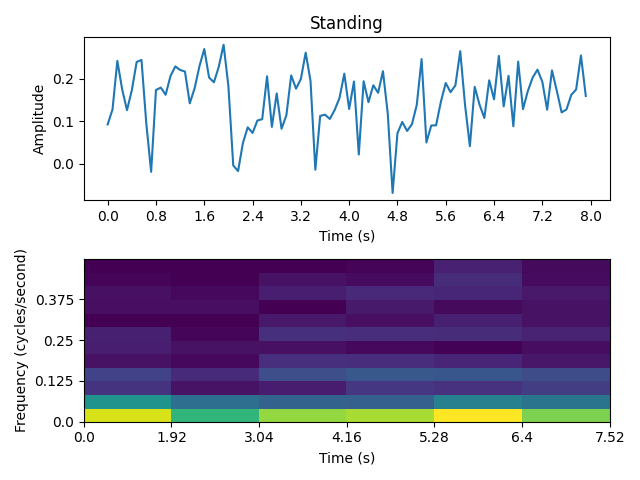

/home/c/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


'Walking at normal speed'

In [55]:
fig, (ax0, ax1) = plt.subplots(2,1)

ax0.set_title("Standing")
ax0.plot(train_data_win[700,:,0])

ax0.set_xticks(np.arange(0,101,10))
ax0.set_xticklabels((np.arange(0,101)/12.5)[::10])
ax0.set_xlabel("Time (s)")
ax0.set_ylabel("Amplitude")

ax1.pcolor(train_fft[700,:,12:,0].T)

ax1.set_yticks(np.arange(0,12,3))
ax1.set_yticklabels(freqs_pos[::3])

ax1.set_xticklabels(end_times/12.5)
ax1.set_ylabel("Frequency (cycles/second)")
ax1.set_xlabel("Time (s)")


fig.tight_layout()
plt.show()

LABELS[train_labels_win[700]]

<IPython.core.display.Javascript object>


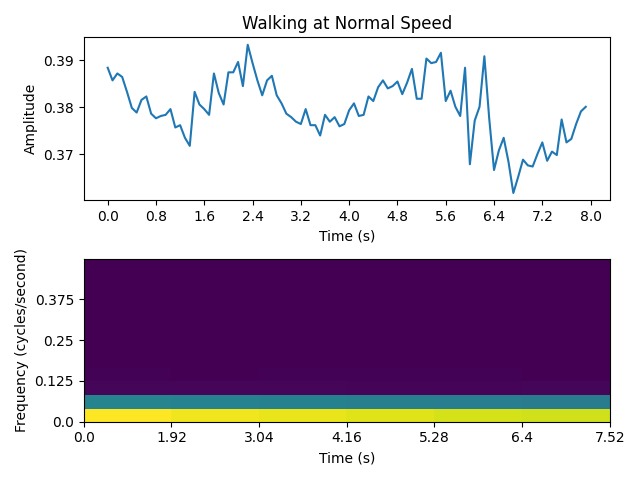

/home/c/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


'Lying down on back'

In [56]:
fig, (ax0, ax1) = plt.subplots(2,1)

ax0.set_title("Walking at Normal Speed")
ax0.plot(train_data_win[600,:,0])

ax0.set_xticks(np.arange(0,101,10))
ax0.set_xticklabels((np.arange(0,101)/12.5)[::10])
ax0.set_xlabel("Time (s)")
ax0.set_ylabel("Amplitude")

ax1.pcolor(train_fft[600,:,12:,0].T)

ax1.set_yticks(np.arange(0,12,3))
ax1.set_yticklabels(freqs_pos[::3])

ax1.set_xticklabels(end_times/12.5)
ax1.set_ylabel("Frequency (cycles/second)")
ax1.set_xlabel("Time (s)")


fig.tight_layout()

plt.show()

LABELS[train_labels_win[600]]

In [57]:
# one hot encoding of output labels

train_labels = np.array(pd.get_dummies(train_labels_win))
test_labels = np.array(pd.get_dummies(test_labels_win))

In [58]:
train_labels_grouped = np.array([CLASSES[i] for i in train_labels_win])
test_labels_grouped = np.array([CLASSES[i] for i in test_labels_win])

In [59]:
train_labels_grouped = np.array(pd.get_dummies(train_labels_grouped))
test_labels_grouped = np.array(pd.get_dummies(test_labels_grouped))

In [60]:
f1_score = F1Score(num_classes=14, average='macro')
f1_score_grouped = F1Score(num_classes=8, average='macro')
f1_score_no_move = F1Score(num_classes=7, average='macro')

if grouped:
    if remove_movement:
        f1_score = f1_score_no_move
    else:
        f1_score = f1_score_grouped

In [61]:
#https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, r, f1_score):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [62]:
#https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
# fit and evaluate a model
def evaluate_model_batch_norm(trainX, trainy, testX, testy, r, f1_score):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [63]:
def evaluate_model_batch_norm_2d(trainX, trainy, testX, testy, r, f1_score):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_bins, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainX.shape[3], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_bins, n_features)))
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score_no_move])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [64]:
"""def evaluate_model_group_norm_2d(trainX, trainy, testX, testy, r, f1_score):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_bins, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainX.shape[3], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_bins, n_features)))
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(tfa.layers.GroupNormalization(groups=4, axis=3))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    #save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score"""

"def evaluate_model_group_norm_2d(trainX, trainy, testX, testy, r, f1_score):\n    verbose, epochs, batch_size = 1, 40, 32\n    n_timesteps, n_bins, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainX.shape[3], trainy.shape[1]\n    model = models.Sequential()\n    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_bins, n_features)))\n    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))\n    model.add(layers.Dropout(0.5))\n    model.add(tfa.layers.GroupNormalization(groups=4, axis=3))\n    model.add(layers.MaxPooling2D(pool_size=2))\n    model.add(layers.Flatten())\n    model.add(layers.Dense(100, activation='relu'))\n    model.add(layers.Dense(n_outputs, activation='softmax'))\n    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])\n    # fit network\n    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)\n    # evaluate model\n 

In [65]:
# fit and evaluate a model
"""def evaluate_model_2(trainX, trainy, testX, testy, r, f1_score):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score"""

"def evaluate_model_2(trainX, trainy, testX, testy, r, f1_score):\n    verbose, epochs, batch_size = 1, 40, 32\n    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]\n    model = models.Sequential()\n    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))\n    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))\n    model.add(layers.Dropout(0.5))\n    model.add(layers.MaxPooling1D(pool_size=2))\n    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))\n    model.add(layers.Dropout(0.5))\n    model.add(layers.MaxPooling1D(pool_size=2))\n    model.add(layers.Flatten())\n    model.add(layers.Dense(100, activation='relu'))\n    model.add(layers.Dense(n_outputs, activation='softmax'))\n    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])\n    # fit network\n    model.fit(trainX, trainy, epochs=epochs, batch_size=ba

In [66]:
def evaluate_model_cnn_lstm(trainX, trainy, testX, testy, r, f1_score):
    verbose, epochs, batch_size = 1, 20, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    n_steps, n_length = 4, 25
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    
    model = models.Sequential()
    model.add(layers.TimeDistributed(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_length, n_features))))
    model.add(layers.TimeDistributed(layers.Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dropout(0.5)))
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.MaxPooling1D(pool_size=2)))
    model.add(layers.TimeDistributed(layers.Flatten()))
    model.add(layers.LSTM(100))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    # LSTM not supported for tflite 
    #save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [67]:
def evaluate_model_cnn_lstm_2d(trainX, trainy, testX, testy, r, f1_score):
    verbose, epochs, batch_size = 1, 20, 32
    n_timesteps, n_bins, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainX.shape[3], trainy.shape[1]
    
    n_steps, n_length = 2, 3
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_bins, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_bins, n_features))
    
    model = models.Sequential()
    model.add(layers.TimeDistributed(layers.Conv2D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_length, n_bins, n_features))))
    model.add(layers.TimeDistributed(layers.Conv2D(filters=64, kernel_size=2, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dropout(0.5)))
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.MaxPooling2D(pool_size=1)))
    model.add(layers.TimeDistributed(layers.Flatten()))
    model.add(layers.LSTM(100))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    #save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [68]:
# summarize scores
def summarize_results(scores, name):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('%s: %.3f%% (+/-%.3f)' % (name, m, s))


In [69]:
# run an experiment
def run_experiment(trainX, trainy, testX, testy, f1_score, use_cnn_lstm, repeats=1):
    # repeat experiment
    scores = list()
    f1scores = list()
    models = list()
        
    for r in range(repeats):
        tf.random.set_seed(r*37)
        if use_cnn_lstm:
            score, f1score = evaluate_model_cnn_lstm(trainX, trainy, testX, testy, r, f1_score)
        else:
            score, f1score = evaluate_model_batch_norm(trainX, trainy, testX, testy, r, f1_score)
        score = score * 100.0
        f1score = f1score * 100.0 
        print('>#%d: Acc %.3f F1 %.3f' % (r+1, score, f1score))
        scores.append(score)
        f1scores.append(f1score)
        models.append
    # summarize results
    summarize_results(scores, 'Accuracy')
    summarize_results(f1scores, 'F1 Score')
    
def run_experiment_2d(trainX, trainy, testX, testy, f1_score, use_cnn_lstm, repeats=1):
    # repeat experiment
    scores = list()
    f1scores = list()
    models = list()
        
    for r in range(repeats):
        tf.random.set_seed(r*37)
        if use_cnn_lstm: 
            score, f1score = evaluate_model_cnn_lstm_2d(trainX, trainy, testX, testy, r, f1_score)
        else:
            score, f1score = evaluate_model_batch_norm_2d(trainX, trainy, testX, testy, r, f1_score)
        score = score * 100.0
        f1score = f1score * 100.0 
        print('>#%d: Acc %.3f F1 %.3f' % (r+1, score, f1score))
        scores.append(score)
        f1scores.append(f1score)
        models.append
    # summarize results
    summarize_results(scores, 'Accuracy')
    summarize_results(f1scores, 'F1 Score')
    
def save_model(model, n):
    # Convert the model.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    model_filename = 'models/cnn_model_' + str(n) + '_' + sensor_pos + '_' + sensor_side + '.tflite' 
    # Save the model.
    with open(model_filename, 'wb') as f:
        f.write(tflite_model)

In [70]:
#score, f1, lstm_model = evaluate_model_cnn_lstm_2d(train_fft, train_labels_grouped, test_fft, test_labels_grouped, 1, f1_score_no_move)

In [71]:
if not perform_fft and not grouped:
    run_experiment(train_data_win, train_labels, test_data_win, test_labels, f1_score, use_cnn_lstm, 5)

Epoch 1/40
70/70 [==============================] - 1s 9ms/step - loss: 1.8110 - accuracy: 0.4208 - f1_score: 0.4177
Epoch 2/40
70/70 [==============================] - 1s 8ms/step - loss: 1.2487 - accuracy: 0.5394 - f1_score: 0.5379
Epoch 3/40
70/70 [==============================] - 1s 9ms/step - loss: 1.0740 - accuracy: 0.5882 - f1_score: 0.5907
Epoch 4/40
70/70 [==============================] - 1s 10ms/step - loss: 0.9559 - accuracy: 0.6285 - f1_score: 0.6331
Epoch 5/40
70/70 [==============================] - 1s 10ms/step - loss: 0.8144 - accuracy: 0.6831 - f1_score: 0.6886
Epoch 6/40
70/70 [==============================] - 1s 9ms/step - loss: 0.7431 - accuracy: 0.7023 - f1_score: 0.7072
Epoch 7/40
70/70 [==============================] - 1s 8ms/step - loss: 0.7053 - accuracy: 0.7234 - f1_score: 0.7277
Epoch 8/40
70/70 [==============================] - 1s 7ms/step - loss: 0.6882 - accuracy: 0.7247 - f1_score: 0.7276
Epoch 9/40
70/70 [==============================] - 1s 7ms/ste

70/70 [==============================] - 1s 9ms/step - loss: 0.3284 - accuracy: 0.8747 - f1_score: 0.8783
Epoch 24/40
70/70 [==============================] - 1s 9ms/step - loss: 0.3875 - accuracy: 0.8523 - f1_score: 0.8570
Epoch 25/40
70/70 [==============================] - 1s 9ms/step - loss: 0.3564 - accuracy: 0.8626 - f1_score: 0.8667
Epoch 26/40
70/70 [==============================] - 1s 9ms/step - loss: 0.3298 - accuracy: 0.8765 - f1_score: 0.8804
Epoch 27/40
70/70 [==============================] - 1s 9ms/step - loss: 0.3134 - accuracy: 0.8791 - f1_score: 0.8835
Epoch 28/40
70/70 [==============================] - 1s 9ms/step - loss: 0.3862 - accuracy: 0.8527 - f1_score: 0.8577
Epoch 29/40
70/70 [==============================] - 1s 9ms/step - loss: 0.3546 - accuracy: 0.8639 - f1_score: 0.8681
Epoch 30/40
70/70 [==============================] - 1s 10ms/step - loss: 0.3542 - accuracy: 0.8657 - f1_score: 0.8707
Epoch 31/40
70/70 [==============================] - 1s 10ms/step -

INFO:tensorflow:Assets written to: /tmp/tmpkv01rwhp/assets


>#2: Acc 45.187 F1 46.426
Epoch 1/40
70/70 [==============================] - 1s 7ms/step - loss: 1.7753 - accuracy: 0.4284 - f1_score: 0.4272
Epoch 2/40
70/70 [==============================] - 1s 9ms/step - loss: 1.2360 - accuracy: 0.5466 - f1_score: 0.5506
Epoch 3/40
70/70 [==============================] - 1s 9ms/step - loss: 1.0278 - accuracy: 0.6007 - f1_score: 0.6020
Epoch 4/40
70/70 [==============================] - 1s 9ms/step - loss: 0.9022 - accuracy: 0.6437 - f1_score: 0.6473
Epoch 5/40
70/70 [==============================] - 1s 9ms/step - loss: 0.8133 - accuracy: 0.6804 - f1_score: 0.6877
Epoch 6/40
70/70 [==============================] - 1s 9ms/step - loss: 0.7182 - accuracy: 0.7171 - f1_score: 0.7225
Epoch 7/40
70/70 [==============================] - 1s 9ms/step - loss: 0.6547 - accuracy: 0.7516 - f1_score: 0.7541
Epoch 8/40
70/70 [==============================] - 1s 9ms/step - loss: 0.6726 - accuracy: 0.7252 - f1_score: 0.7309
Epoch 9/40
70/70 [====================

INFO:tensorflow:Assets written to: /tmp/tmp7ekzfn4s/assets


>#3: Acc 51.070 F1 48.800
Epoch 1/40
70/70 [==============================] - 1s 7ms/step - loss: 1.7456 - accuracy: 0.4302 - f1_score: 0.4355
Epoch 2/40
70/70 [==============================] - 1s 9ms/step - loss: 1.2338 - accuracy: 0.5501 - f1_score: 0.5465
Epoch 3/40
70/70 [==============================] - 1s 9ms/step - loss: 1.0268 - accuracy: 0.6097 - f1_score: 0.6127
Epoch 4/40
70/70 [==============================] - 1s 9ms/step - loss: 0.9204 - accuracy: 0.6365 - f1_score: 0.6437
Epoch 5/40
70/70 [==============================] - 1s 9ms/step - loss: 0.7758 - accuracy: 0.6925 - f1_score: 0.6976
Epoch 6/40
70/70 [==============================] - 1s 9ms/step - loss: 0.7982 - accuracy: 0.6795 - f1_score: 0.6887
Epoch 7/40
70/70 [==============================] - 1s 9ms/step - loss: 0.6722 - accuracy: 0.7301 - f1_score: 0.7354
Epoch 8/40
70/70 [==============================] - 1s 9ms/step - loss: 0.6960 - accuracy: 0.7265 - f1_score: 0.7298
Epoch 9/40
70/70 [====================

INFO:tensorflow:Assets written to: /tmp/tmpqqf25kh2/assets


>#4: Acc 43.583 F1 44.432
Epoch 1/40
70/70 [==============================] - 1s 11ms/step - loss: 1.8139 - accuracy: 0.4257 - f1_score: 0.4214
Epoch 2/40
70/70 [==============================] - 1s 13ms/step - loss: 1.2521 - accuracy: 0.5497 - f1_score: 0.5518
Epoch 3/40
70/70 [==============================] - 1s 12ms/step - loss: 1.0449 - accuracy: 0.5994 - f1_score: 0.5995
Epoch 4/40
70/70 [==============================] - 1s 12ms/step - loss: 0.8980 - accuracy: 0.6509 - f1_score: 0.6542
Epoch 5/40
70/70 [==============================] - 1s 12ms/step - loss: 0.8320 - accuracy: 0.6665 - f1_score: 0.6688
Epoch 6/40
70/70 [==============================] - 1s 12ms/step - loss: 0.7930 - accuracy: 0.6831 - f1_score: 0.6855
Epoch 7/40
70/70 [==============================] - 1s 12ms/step - loss: 0.6815 - accuracy: 0.7274 - f1_score: 0.7324
Epoch 8/40
70/70 [==============================] - 1s 12ms/step - loss: 0.6781 - accuracy: 0.7390 - f1_score: 0.7435
Epoch 9/40
70/70 [============

INFO:tensorflow:Assets written to: /tmp/tmpwsc1rpwv/assets


>#5: Acc 46.791 F1 45.590
[50.267380475997925, 45.18716633319855, 51.06951594352722, 43.58288645744324, 46.79144322872162]
Accuracy: 47.380% (+/-2.882)
[47.94299900531769, 46.42556607723236, 48.800286650657654, 44.432321190834045, 45.59037387371063]
F1 Score: 46.638% (+/-1.574)


In [72]:
if not perform_fft and grouped:
    run_experiment(train_data_win, train_labels_grouped, test_data_win, test_labels_grouped, f1_score, use_cnn_lstm, 5)

In [73]:
if perform_fft and not grouped:
    run_experiment_2d(train_fft, train_labels, test_fft, test_labels, f1_score, use_cnn_lstm, 5)

In [ ]:
if perform_fft and grouped:
    run_experiment_2d(train_fft, train_labels_grouped, test_fft, test_labels_grouped, f1_score, use_cnn_lstm, 5)

In [74]:
# for confusion matrix

def get_predictions_from_saved_model(model_filename, testX):
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_filename)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    predictions = []
    for x in testX:
        interpreter.set_tensor(input_details[0]['index'], [x])
    
        interpreter.invoke()
    
        predictions.append(interpreter.get_tensor(output_details[0]['index']))
    
    return np.array(predictions)

In [75]:
tf_filename = 'cnn_model_1_Chest_Right'
tf_filepath = 'models/' + tf_filename + '.tflite'

if perform_fft:
    predictions = get_predictions_from_saved_model(tf_filepath, np.array(test_fft, dtype=np.float32))
else:
    predictions = get_predictions_from_saved_model(tf_filepath, np.array(test_data_win, dtype=np.float32))

In [76]:
predictions.shape

(374, 1, 14)

In [77]:
np.std(predictions, axis=2)

array([[0.11745954],
       [0.16868573],
       [0.23903173],
       [0.23728669],
       [0.15809439],
       [0.14022063],
       [0.1385317 ],
       [0.20053993],
       [0.25626123],
       [0.2394086 ],
       [0.16618793],
       [0.2030429 ],
       [0.2333559 ],
       [0.23280983],
       [0.23301035],
       [0.23420678],
       [0.2360302 ],
       [0.23715651],
       [0.23694018],
       [0.25035474],
       [0.23047166],
       [0.16627324],
       [0.16596903],
       [0.1654619 ],
       [0.18509315],
       [0.24330689],
       [0.25162268],
       [0.25218293],
       [0.25224152],
       [0.2516612 ],
       [0.25051227],
       [0.2501528 ],
       [0.22039488],
       [0.18091539],
       [0.16056702],
       [0.16113776],
       [0.16137841],
       [0.15838207],
       [0.25753888],
       [0.25753888],
       [0.25753888],
       [0.25753886],
       [0.25753886],
       [0.25753886],
       [0.25727192],
       [0.25712347],
       [0.25694755],
       [0.256

In [78]:
pred_labels = np.argmax(predictions, axis=2)

In [79]:
# LSTM confusion matrix
"""n_steps, n_length = 2, 3
n_timesteps, n_bins, n_features, n_outputs = train_fft.shape[1], train_fft.shape[2], train_fft.shape[3], train_labels_grouped.shape[1]
testX = test_fft.reshape((test_fft.shape[0], n_steps, n_length, n_bins, n_features))
    
predictions = lstm_model.predict([testX])
pred_labels = np.argmax(predictions, axis=1)"""

'n_steps, n_length = 2, 3\nn_timesteps, n_bins, n_features, n_outputs = train_fft.shape[1], train_fft.shape[2], train_fft.shape[3], train_labels_grouped.shape[1]\ntestX = test_fft.reshape((test_fft.shape[0], n_steps, n_length, n_bins, n_features))\n    \npredictions = lstm_model.predict([testX])\npred_labels = np.argmax(predictions, axis=1)'

<IPython.core.display.Javascript object>


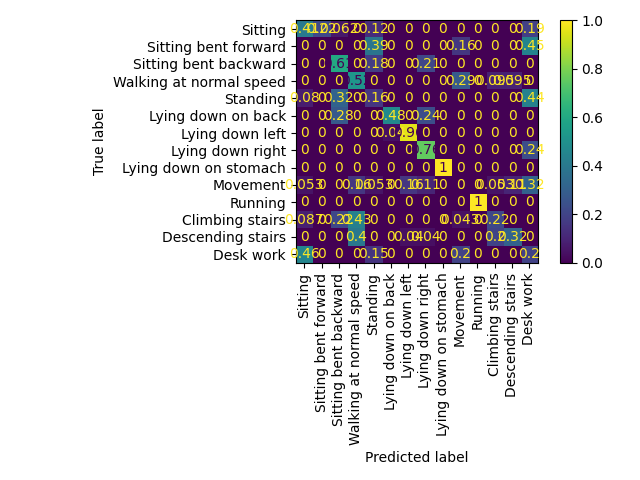

In [80]:
if grouped:
    lbls = test_labels_grouped
    if remove_movement:
        disp_lbls = CLASS_LABELS_NOMO
    else:
        disp_lbls = CLASS_LABELS
else:
    lbls = test_labels
    disp_lbls = LABELS
cm = metrics.confusion_matrix(np.argmax(lbls, axis=1), pred_labels, normalize='true') 

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_lbls.values())
disp.plot(xticks_rotation='vertical')
plt.tight_layout()
plt.show()
plt.savefig(tf_filename + '.png')

In [81]:
standardisation = [31.55737817287445, 33.42026770114899, 30.02980649471283, 33.23397934436798, 30.29060959815979]
epochs_10 = [42.473918199539185, 39.71683979034424, 29.88077402114868, 39.30700421333313, 46.050670742988586]
epochs_20 = [41.840535402297974, 33.196720480918884, 37.89120614528656, 45.90163826942444, 38.226526975631714]
epochs_30 = [40.387481451034546, 45.566317439079285, 36.810728907585144, 43.3308482170105, 36.62444055080414]
epochs_40 = [39.82861340045929, 32.82414376735687, 42.324888706207275, 46.460506319999695, 43.66616904735565]

epochs_40_full_data = [45.42857110500336, 45.42857110500336, 49.714285135269165, 46.00000083446503, 47.14285731315613]
epochs_40_full_data_batch_normalisation = [47.999998927116394, 51.99999809265137, 46.57142758369446, 45.42857110500336, 46.00000083446503]
epochs_40_full_data_batch_normalisation_grouped = [62.98399567604065, 59.21528339385986, 63.810014724731445, 62.13216185569763, 55.60144782066345]


window_50_epochs_40 = [37.38650977611542, 37.87289261817932, 40.4020756483078, 38.197147846221924, 37.02983260154724]
window_150_epochs_40 = [46.45358920097351, 40.49912393093109, 42.3380047082901, 37.25919425487518, 44.78984177112579]

window_100_steps_50 = [63.56968283653259, 66.74816608428955, 62.59168982505798, 59.90220308303833, 58.92420411109924]
window_100_steps_25 = [63.499999046325684, 66.12499952316284, 63.24999928474426, 67.37499833106995, 62.87500262260437]

kernel_6 = [64.79217410087585, 46.454766392707825, 67.48166084289551, 68.9486563205719, 67.97065734863281]
kernel_9 = [57.21271634101868, 67.48166084289551, 65.28117656707764, 53.05623412132263, 46.21026813983917]

fft_grouped = [70.9046483039856, 69.68215107917786, 72.86063432693481, 72.86063432693481, 71.3936448097229]
fft_filtering_sqr = [68.21516156196594, 66.25916957855225, 67.48166084289551, 66.9926643371582, 67.48166084289551]
fft_filtering_01 = [70.66014409065247, 73.10513257980347, 73.10513257980347, 70.17114758491516, 71.8826413154602]

movement_removed = [76.40750408172607, 81.23324513435364, 78.28418016433716, 77.47989296913147, 75.33512115478516]

fft_ungrouped = [34.2298299074173, 35.4523241519928, 36.43031716346741, 37.408313155174255, 32.51833617687225]


layers_3_10 = [35.99105775356293, 33.79284739494324, 41.09537899494171, 41.46795868873596, 42.17585623264313]
layers_3_batch_16 = [46.00000083446503, 44.57142949104309, 44.85714137554169, 44.57142949104309, 46.00000083446503]
layers_3_batch_32 = [45.42857110500336, 45.42857110500336, 49.714285135269165, 46.00000083446503, 47.14285731315613]
layers_3_batch_64 = [46.00000083446503, 44.85714137554169, 44.85714137554169, 42.85714328289032, 44.57142949104309]


In [82]:
"""fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Standardisation')
ax1.boxplot([standardisation, epochs_10], labels=['Standardisation', 'No Standardisation'])
plt.show()"""

"fig1, ax1 = plt.subplots()\nax1.set_ylabel('Accuracy')\nax1.set_title('Standardisation')\nax1.boxplot([standardisation, epochs_10], labels=['Standardisation', 'No Standardisation'])\nplt.show()"

In [83]:
"""fig1, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Number of Epochs')
ax1.boxplot([epochs_10, epochs_20, epochs_30, epochs_40], labels=['10', '20', '30', '40'])
plt.show()"""

"fig1, ax1 = plt.subplots()\nax1.set_xlabel('Epochs')\nax1.set_ylabel('Accuracy')\nax1.set_title('Number of Epochs')\nax1.boxplot([epochs_10, epochs_20, epochs_30, epochs_40], labels=['10', '20', '30', '40'])\nplt.show()"

In [84]:
"""fig1, ax1 = plt.subplots()
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Accuracy')
ax1.set_title('Batch Size')
ax1.boxplot([layers_3_batch_16, layers_3_batch_32, layers_3_batch_64], labels=['16', '32', '64'])
plt.show()"""

"fig1, ax1 = plt.subplots()\nax1.set_xlabel('Batch Size')\nax1.set_ylabel('Accuracy')\nax1.set_title('Batch Size')\nax1.boxplot([layers_3_batch_16, layers_3_batch_32, layers_3_batch_64], labels=['16', '32', '64'])\nplt.show()"

In [85]:
"""fig1, ax1 = plt.subplots()
ax1.set_xlabel('Window Size')
ax1.set_ylabel('Accuracy')
ax1.set_title('Window Size')
ax1.boxplot([window_50_epochs_40, epochs_40, window_150_epochs_40], labels=['50', '100', '150'])
plt.show()"""

"fig1, ax1 = plt.subplots()\nax1.set_xlabel('Window Size')\nax1.set_ylabel('Accuracy')\nax1.set_title('Window Size')\nax1.boxplot([window_50_epochs_40, epochs_40, window_150_epochs_40], labels=['50', '100', '150'])\nplt.show()"

In [86]:
"""fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.boxplot([epochs_10, layers_3_10, epochs_30, layers_3_30], labels=['1', '2', '3','4'])
plt.show()"""

"fig1, ax1 = plt.subplots()\nax1.set_ylabel('Accuracy')\nax1.boxplot([epochs_10, layers_3_10, epochs_30, layers_3_30], labels=['1', '2', '3','4'])\nplt.show()"

In [87]:
"""fig1, ax1 = plt.subplots()
ax1.set_xlabel('Step Size')
ax1.set_ylabel('Accuracy')
ax1.set_title('Step Size With Window Size 100')
ax1.boxplot([epochs_40_full_data_batch_normalisation_grouped, window_100_steps_25, window_100_steps_50], labels=['5', '25', '50'])
plt.show()"""

"fig1, ax1 = plt.subplots()\nax1.set_xlabel('Step Size')\nax1.set_ylabel('Accuracy')\nax1.set_title('Step Size With Window Size 100')\nax1.boxplot([epochs_40_full_data_batch_normalisation_grouped, window_100_steps_25, window_100_steps_50], labels=['5', '25', '50'])\nplt.show()"

In [88]:
"""fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Batch Normalisation')
ax1.boxplot([epochs_40_full_data, epochs_40_full_data_batch_normalisation], labels=['No Normalisation', 'Batch Normalisation'])
plt.show()"""

"fig1, ax1 = plt.subplots()\nax1.set_ylabel('Accuracy')\nax1.set_title('Batch Normalisation')\nax1.boxplot([epochs_40_full_data, epochs_40_full_data_batch_normalisation], labels=['No Normalisation', 'Batch Normalisation'])\nplt.show()"

In [89]:
"""fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Grouping Activities')
ax1.boxplot([epochs_40_full_data_batch_normalisation, epochs_40_full_data_batch_normalisation_grouped], labels=['Ungrouped', 'Grouped'])
plt.show()"""

"fig1, ax1 = plt.subplots()\nax1.set_ylabel('Accuracy')\nax1.set_title('Grouping Activities')\nax1.boxplot([epochs_40_full_data_batch_normalisation, epochs_40_full_data_batch_normalisation_grouped], labels=['Ungrouped', 'Grouped'])\nplt.show()"

In [90]:
"""fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Grouping Activities')
ax1.boxplot([epochs_40_full_data_batch_normalisation, epochs_40_full_data_batch_normalisation_grouped], labels=['Ungrouped', 'Grouped'])
plt.show()"""

"fig1, ax1 = plt.subplots()\nax1.set_ylabel('Accuracy')\nax1.set_title('Grouping Activities')\nax1.boxplot([epochs_40_full_data_batch_normalisation, epochs_40_full_data_batch_normalisation_grouped], labels=['Ungrouped', 'Grouped'])\nplt.show()"

In [91]:
"""fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Fourier Transform')
ax1.boxplot([epochs_40_full_data_batch_normalisation_grouped, fft_grouped, fft_filtering_01], labels=['Original', 'FFt', 'Filtered FFT'])
plt.show()"""

"fig1, ax1 = plt.subplots()\nax1.set_ylabel('Accuracy')\nax1.set_title('Fourier Transform')\nax1.boxplot([epochs_40_full_data_batch_normalisation_grouped, fft_grouped, fft_filtering_01], labels=['Original', 'FFt', 'Filtered FFT'])\nplt.show()"